## 003 Pilot an RW model in pymc

Date: 21.Jul.2022

### Purpose

Implement a complete pymc RW model

### Outline of Plan

1. Load raw data
2. Implement a pymc model using [this link](https://colab.research.google.com/github/ricardoV94/stats/blob/master/modelling/RL_PyMC.ipynb)
3. Sample and view the prior predictive simulation
4. Sample the posterior distribution
5. Sample and view the posterior predictive simulation

### What we did in this notebook

1. Implemented pymc rw model using pm.Potential, which is limited in further analysis
2. Implemented pymc rw model using pm.Bernoulli, which allows likelihood, prior + posterior predictive checks
3. Simulated priors from norm.rvs
4. Simulated posteriors from pymc trace
5. Parameter transformation for alpha parameter [invlogit] (successful, but post-transform distribution is not Gaussian)
6. Parameter transformation for beta [np.exp] (unsuccessful, sampling is very poor)
7. Sampling from transformed alpha and halfnormal beta (best performing)


In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
# from scipy.optimize import minimize
# from scipy.special import logsumexp, expit, logit
# from scipy.stats import norm, multivariate_normal
# import numdifftools as nd

from sys import path

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data, plotting # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [57]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## pymc RW model for one subject (pm.Potential implementation)

In [238]:
act = longform[(longform['PID']==pid_list[1])&(longform['Type']=='money')]['Action'].values
rew = longform[(longform['PID']==pid_list[1])&(longform['Type']=='money')]['Reward'].values

In [239]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by aesara.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the aesara.scan fn argument:
        fn=lamba action, reward, Qs, alpha: at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [240]:
# Transform the variables into appropriate Aesara objects
rewards_ = at.as_tensor_variable(rew, dtype='int32')
actions_ = at.as_tensor_variable(act, dtype='int32')

alpha = at.scalar("alpha")
beta = at.scalar("beta")

# Initialize the Q table
Qs = 0.5 * at.ones((2,), dtype='float64')

# Compute the Q values for each trial
Qs, _ = aesara.scan(
    fn=update_Q,
    sequences=[actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

# Apply the softmax transformation
Qs = Qs * beta
logp_actions = Qs - at.logsumexp(Qs, axis=1, keepdims=True)

# Calculate the negative log likelihod of the observed actions
logp_actions = logp_actions[at.arange(actions_.shape[0]-1), actions_[1:]]
neg_loglike = -at.sum(logp_actions)

In [241]:
aesara_llik_td = aesara.function(inputs=[alpha, beta], outputs=neg_loglike, on_unused_input="ignore")
result = aesara_llik_td(0.5, 1)
float(result)

33.6784210570752

In [242]:
def aesara_llik_td(alpha, beta, actions, rewards):
    rewards = at.as_tensor_variable(rewards, dtype='int32')
    actions = at.as_tensor_variable(actions, dtype='int32')

    # Compute the Qs values
    Qs = 0.5 * at.ones((2,), dtype='float64')
    Qs, updates = aesara.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - at.logsumexp(Qs, axis=1, keepdims=True)

    # Calculate the log likelihood of the observed actions
    logp_actions = logp_actions[at.arange(actions.shape[0]-1), actions[1:]]
    return at.sum(logp_actions)  # PyMC expects the standard log-likelihood

In [243]:
with pm.Model() as m:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.HalfNormal('beta', 10)

    like = pm.Potential('like', aesara_llik_td(alpha, beta, act, rew))

    tr = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

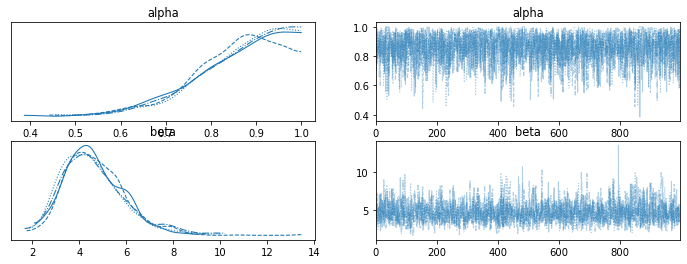

In [244]:
az.plot_trace(tr, var_names=['alpha', 'beta'])

## pymc RW model for one subject (pm.Bernoulli implementation)

In [189]:
actions = longform[(longform['PID']==pid_list[1])&(longform['Type']=='money')]['Action'].values
rewards = longform[(longform['PID']==pid_list[1])&(longform['Type']=='money')]['Reward'].values

In [190]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by aesara.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the aesara.scan fn argument:
        fn=lamba action, reward, Qs, alpha: at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [185]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = at.as_tensor_variable(rewards, dtype='int32')
    actions = at.as_tensor_variable(actions, dtype='int32')

    # Compute the Qs values
    Qs = 0.5 * at.ones((2,), dtype='float64')
    Qs, updates = aesara.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs = Qs * beta
    logp_actions = Qs - at.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return at.exp(logp_actions[:, 1])

In [186]:
with pm.Model() as m_bern:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.HalfNormal('beta', 1)

    action_probs = right_action_probs(alpha, beta, actions, rewards)
    like = pm.Bernoulli('like', p=action_probs, observed=actions)

    tr_bern = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

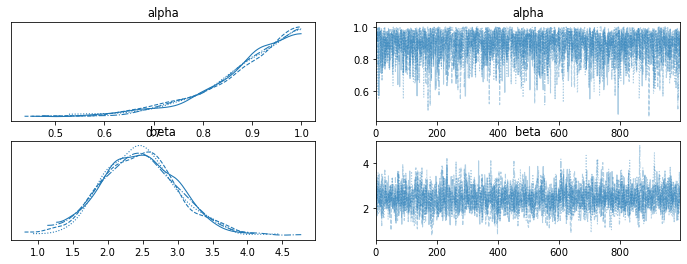

In [187]:
az.plot_trace(tr_bern, var_names=['alpha', 'beta'])

In [118]:
with m_bern:
    tr_bern.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(tr_bern, extend_inferencedata=True)

In [119]:
tr_bern

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [120]:
tr_bern.prior_predictive.like.shape

(1, 500, 59)

## pymc RW model for one subject (pm.Bernoulli implementation + parameter transform)

In [334]:
act = longform[(longform['PID']==pid_list[12])&(longform['Type']=='other')]['Action'].values
rew = longform[(longform['PID']==pid_list[12])&(longform['Type']=='other')]['Reward'].values

In [335]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by aesara.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the aesara.scan fn argument:
        fn=lamba action, reward, Qs, alpha: at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [336]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = at.as_tensor_variable(rewards, dtype='int32')
    actions = at.as_tensor_variable(actions, dtype='int32')

    # Compute the Qs values
    Qs = 0.5 * at.ones((2,), dtype='float64')
    Qs, updates = aesara.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - at.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return at.exp(logp_actions[:, 1]) 

In [337]:
with pm.Model() as m_reparam:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.HalfNormal('beta', 10)
    alpha_transformed = pm.Deterministic('alpha_transformed', pm.math.invlogit(alpha))
    # beta_transformed = pm.Deterministic('beta_transformed', pm.math.exp(beta))
    # alpha = pm.Beta('alpha', 1, 1)
    # beta = pm.HalfNormal('beta', 10)

    action_probs = right_action_probs(alpha_transformed, beta, act, rew)
    like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

    tr_reparam = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'alpha_transformed'}>], dtype=object)

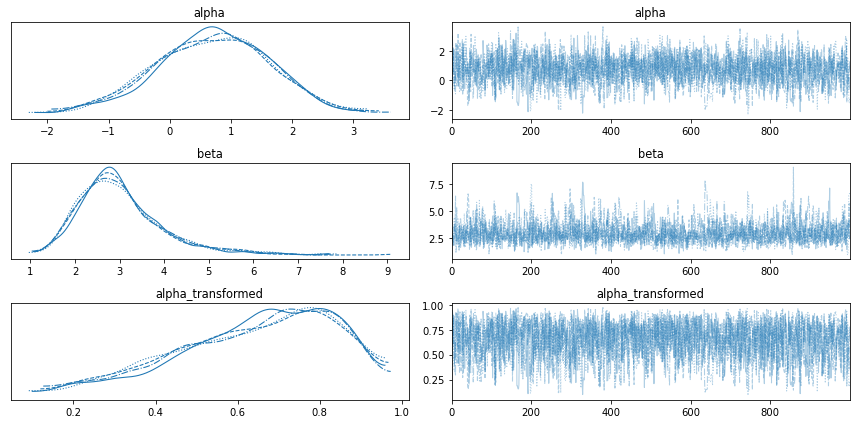

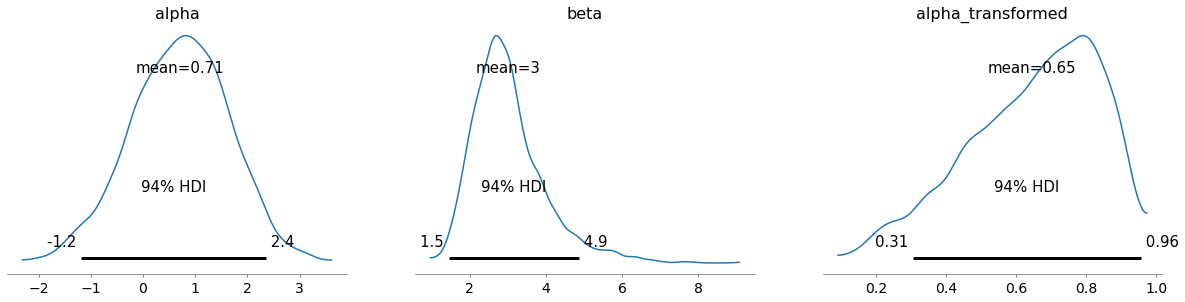

In [344]:
az.plot_trace(tr_reparam, var_names=['alpha', 'beta', 'alpha_transformed'])
plt.tight_layout()
az.plot_posterior(tr_reparam, var_names=['alpha', 'beta', 'alpha_transformed'])

In [128]:
with m_reparam:
    tr_reparam.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(tr_reparam, extend_inferencedata=True)

In [129]:
tr_reparam

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [130]:
tr_reparam.prior_predictive.like.shape

(1, 500, 59)

## pymc RW model for one subject (pm.Bernoulli implementation + beta priors from prev model)

In [339]:
act = longform[(longform['PID']==pid_list[12])&(longform['Type']=='other')]['Action'].values
rew = longform[(longform['PID']==pid_list[12])&(longform['Type']=='other')]['Reward'].values

In [340]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by aesara.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the aesara.scan fn argument:
        fn=lamba action, reward, Qs, alpha: at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = at.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [341]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = at.as_tensor_variable(rewards, dtype='int32')
    actions = at.as_tensor_variable(actions, dtype='int32')

    # Compute the Qs values
    Qs = 0.5 * at.ones((2,), dtype='float64')
    Qs, updates = aesara.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - at.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return at.exp(logp_actions[:, 1]) 

In [342]:
with pm.Model() as m_old_priors:
    alpha = pm.Normal(f"alpha", 0.5, 0.25)
    beta = pm.Gamma(f"beta", alpha=3, beta=1.5)
    # alpha_transformed = pm.Deterministic('alpha_transformed', pm.math.invlogit(alpha))
    # beta_transformed = pm.Deterministic('beta_transformed', pm.math.exp(beta))
    # alpha = pm.Beta('alpha', 1, 1)
    # beta = pm.HalfNormal('beta', 10)

    action_probs = right_action_probs(alpha, beta, act, rew)
    like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

    tr_old_priors = pm.sample(initvals={'alpha': 0.5, 'beta': 3})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

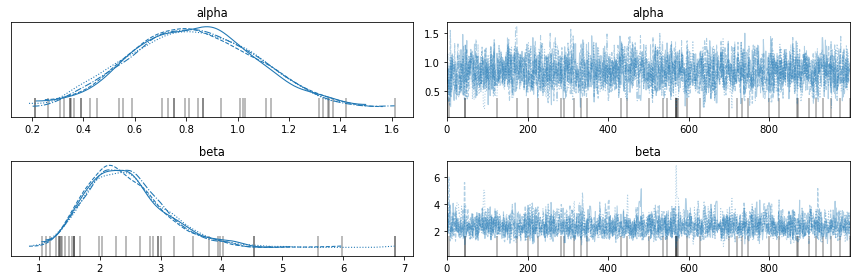

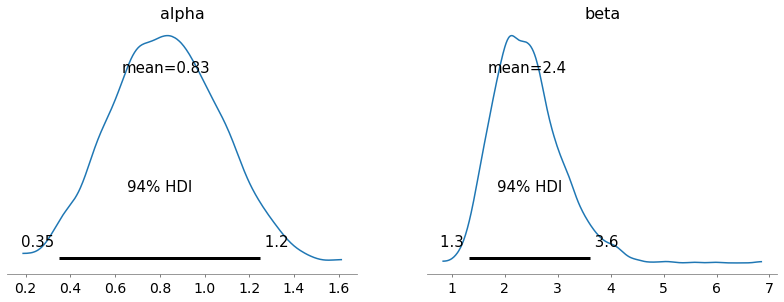

In [346]:
az.plot_trace(tr_old_priors, var_names=['alpha', 'beta'])
plt.tight_layout()
az.plot_posterior(tr_old_priors, var_names=['alpha', 'beta'])

## Prior predictive simulation

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

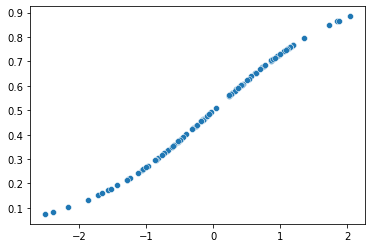

In [308]:
from scipy.special import expit
from scipy.stats import norm
xs = norm.rvs(loc=0, scale=1, size=100)
ys = expit(xs)
sns.scatterplot(xs, ys)

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 10.0)

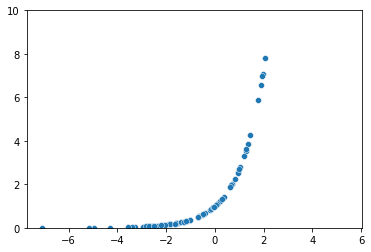

In [309]:
xs = norm.rvs(loc=0, scale=2.5, size=100)
ys = np.exp(xs)
sns.scatterplot(xs, ys)
plt.ylim(0,10)